In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import os
import time
import re

# 글씨 깨짐 방지 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [2]:
def timeit(func):
    """Decorator to measure the execution time of a function."""
    def wrapper(*args, **kwargs):
        start_time = time.time()  # 시작 시간 기록
        result = func(*args, **kwargs)  # 함수 실행
        end_time = time.time()  # 종료 시간 기록
        print(f"Function '{func.__name__}' executed in {end_time - start_time:.2f} seconds")
        return result
    return wrapper

In [3]:
class BaseAnalyzer:
    # 데이터의 상관 행렬을 계산하는 기본 분석 클래스
    def __init__(self, data):
        self.data = data  # 인스턴스 변수로 데이터 저장

    def calculate_correlation(self):
        # 데이터의 상관 행렬을 계산하여 반환
        return self.data.corr()

    @classmethod
    def from_csv(cls, file_path):
        # CSV 파일에서 데이터를 로드하여 인스턴스를 생성하는 클래스 메서드
        data = pd.read_csv(file_path)
        return cls(data)

In [4]:
class DataHandler:
    # 데이터 처리 클래스: 데이터 로드 및 전처리 기능을 제공
    def __init__(self, data_path):
        self._data_path = data_path  # 비공개 속성으로 데이터 경로 저장
        self._data = None  # 비공개 속성으로 데이터 저장

    def load_data(self):
        # 엑셀 파일에서 데이터를 로드하고 결측치를 전방 채우기 방식으로 처리
        try:
            self._data = pd.read_excel(self._data_path)
            self._data.fillna(method='ffill', inplace=True)
        except FileNotFoundError:
            print(f"File not found: {self._data_path}")
        except ValueError as e:
            print(f"Value error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    @property
    def data(self):
        # 데이터에 대한 접근을 제공하는 프로퍼티
        if self._data is None:
            self.load_data()  # 데이터가 없으면 로드
        return self._data

In [5]:
class CorrelationAnalyzer(BaseAnalyzer):
    # 상관 분석 클래스: 상관 행렬 시각화 및 상관계수 극단값 찾기 기능을 제공
    @timeit
    def visualize_correlation_and_find_extremes(self, interest_rate_column):
        # 상관 행렬을 시각화하고, 가장 높은/낮은 상관계수를 가진 변수를 출력
        correlation_matrix = self.calculate_correlation().drop('년도', axis=0).drop('년도', axis=1)
        
        # 상관계수가 가장 높은 변수와 가장 낮은 변수 찾기
        interest_rate_correlations = correlation_matrix[interest_rate_column].drop(interest_rate_column)
        max_correlation_variable = interest_rate_correlations.idxmax()
        max_correlation_value = interest_rate_correlations.max()
        min_correlation_variable = interest_rate_correlations.idxmin()
        min_correlation_value = interest_rate_correlations.min()

        # 변수 이름 포맷 변경
        max_correlation_variable_formatted = self.format_variable_name(max_correlation_variable)
        min_correlation_variable_formatted = self.format_variable_name(min_correlation_variable)

        # 결과 출력
        print(f"가장 상관계수가 높은 변수는 {max_correlation_variable_formatted}이고, 상관계수는 {max_correlation_value:.3f}입니다.")
        print(f"가장 상관계수가 낮은 변수는 {min_correlation_variable_formatted}이고, 상관계수는 {min_correlation_value:.3f}입니다.")

        # 히트맵 그리기 (숫자 없이)
        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(
            correlation_matrix, 
            annot=False,  # 숫자 표시 안 함
            cmap='coolwarm', 
            fmt=".2f", 
            mask=mask
        )
        plt.title('상관 행렬 (독립 변수 간)', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show(block=False)
        
        return correlation_matrix

    @staticmethod
    def format_variable_name(name):
        # 변수 이름 포맷 변경: _를 띄어쓰기로, 숫자 사이의 _를 ~로 변경
        name = re.sub(r'_', ' ', name)
        name = re.sub(r'(\d) (\d)', r'\1~\2', name)
        return name

    @timeit
    def visualize_grouped_correlations(self, interest_rate_column):
        # 그룹별 상관 행렬을 시각화
        correlation_matrix = self.calculate_correlation()
        groups = {
            "환율 관련": ['원달러_환율', '원달러_절상율', '엔달러_환율', '엔달러_절상율', '원100엔_환율', '원100엔_절상율'],
            "채권 및 금리 관련": ['국고채_3년', '국고채_5년', '국고채_10년', '회사채_3년', '평균', 'CD_91물', '콜금리', '평균'],
            "소비 관련": ['식료품_비주류음료', '주류_및_담배', '의류_및_신발', '주택_수도_전기_및_연료', '가정용품_및_가사_서비스', '보건', '교통', '통신', '오락_및_문화', '교육', '음식_및_숙박', '기타_상품_및_서비스'],
            "주택 매매 가격 변동률": ['수도권_주택매매가격변동률', '지방_주택매매가격변동률'],
            "전체": correlation_matrix.columns.drop(interest_rate_column).tolist()  # 전체 그룹 추가
        }

        colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'black']  # 각 그룹에 대한 색상

        for (group_name, variables), color in zip(groups.items(), colors):
            group_correlations = correlation_matrix.loc[variables, interest_rate_column].dropna()
            sorted_group_correlations = group_correlations.abs().sort_values(ascending=False)

            plt.figure(figsize=(15,4))
            sorted_group_correlations.plot(kind='bar', color=color)
            plt.title(f"{group_name} - 금리와의 상관관계")
            plt.ylabel('상관계수 (절대값)')
            plt.xlabel('변수')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

In [6]:
class RegressionAnalyzer(BaseAnalyzer):
    # 회귀 분석 클래스: 회귀 분석 수행 및 결과 저장 기능을 제공
    @timeit
    def perform_regression(self, dependent_var, independent_var):
        # 주어진 종속 변수와 독립 변수에 대해 회귀 분석을 수행
        model = ols(f'{dependent_var} ~ {independent_var}', data=self.data).fit()
        return model

    @timeit
    def analyze_interest_rate_effects(self, interest_rate_column):
        # 금리와 다른 변수들 간의 회귀 분석을 수행하고 결과를 저장
        columns = [
            '원달러_환율', '원달러_절상율', '엔달러_환율', '엔달러_절상율', 
            '원100엔_환율', '원100엔_절상율', '가계신용', '가계대출', '판매신용', 
            'GDP대비_가계부채_비율', 'KOSPI', 'KOSDAQ', '고용률', '국고채_3년', 
            '국고채_5년', '국고채_10년', '회사채_3년', '평균', 'CD_91물', '콜금리', 
            '평균', '수출_금액', '수출_증감률', '수입_금액', '수입_증감률', '수지', 
            '소비자물가_총지수2020', '소비자물가상승률', '식료품_비주류음료', 
            '주류_및_담배', '의류_및_신발', '주택_수도_전기_및_연료', 
            '가정용품_및_가사_서비스', '보건', '교통', '통신', '오락_및_문화', 
            '교육', '음식_및_숙박', '기타_상품_및_서비스', '전국_주택매매가격변동률', 
            '수도권_주택매매가격변동률', '지방_주택매매가격변동률'
        ]

        # 산점도 저장을 위한 디렉토리 생성
        os.makedirs('scatter_plots', exist_ok=True)

        try:
            with open('all_regression_summaries.txt', 'w') as f:
                for column in columns:
                    if column != interest_rate_column:
                        try:
                            model = self.perform_regression(column, interest_rate_column)
                            f.write(f'Regression summary for {column} vs {interest_rate_column}:\n')
                            f.write(model.summary().as_text())
                            f.write('\n\n' + '='*80 + '\n\n')

                            # 산점도 저장
                            plot_path = f'scatter_plots/{column}_vs_{interest_rate_column}.png'
                            sns.lmplot(x=interest_rate_column, y=column, data=self.data, aspect=2)
                            plt.title(f'{column} vs {interest_rate_column}')
                            plt.savefig(plot_path)
                            plt.close()

                            # 산점도 경로를 파일에 기록
                            f.write(f'Scatter plot saved at: {plot_path}\n\n')
                        except FileNotFoundError as e:
                            f.write(f"File not found for {column}: {e}\n\n")
                            print(f"File not found for {column}: {e}")
                        except ValueError as e:
                            f.write(f"Value error for {column}: {e}\n\n")
                            print(f"Value error for {column}: {e}")
                        except Exception as e:
                            f.write(f"An unexpected error occurred with {column}: {e}\n\n")
                            print(f"An unexpected error occurred with {column}: {e}")
        except Exception as e:
            print(f"Failed to write to file: {e}")

In [7]:
class CorrelationSearcher:
    # 상관관계 검색 클래스: 사용자 입력을 통해 상관계수를 검색하는 기능을 제공
    def __init__(self, correlation_matrix, interest_rate_column):
        self.correlation_matrix = correlation_matrix
        self.interest_rate_column = interest_rate_column

    def search_correlation(self):
        # 사용자 입력을 통해 상관계수를 검색
        interest_rate_correlations = self.correlation_matrix[self.interest_rate_column].drop(self.interest_rate_column)
        while True:
            user_input = input("상관관계를 확인할 변수를 입력하세요 (종료하려면 '종료' 입력): ")
            if user_input == "종료":
                break
            if user_input in interest_rate_correlations.index:
                correlation_value = interest_rate_correlations[user_input]
                print(f"{user_input}와(과) {self.interest_rate_column}의 상관계수는 {correlation_value:.3f}입니다.")
            else:
                print(f"'{user_input}' 변수는 데이터에 존재하지 않습니다. 다시 입력해 주세요.")

/var/folders/1j/d_cg9rn93xn390pf9vs669bh0000gn/T/ipykernel_20449/2142271783.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self._data.fillna(method='ffill', inplace=True)


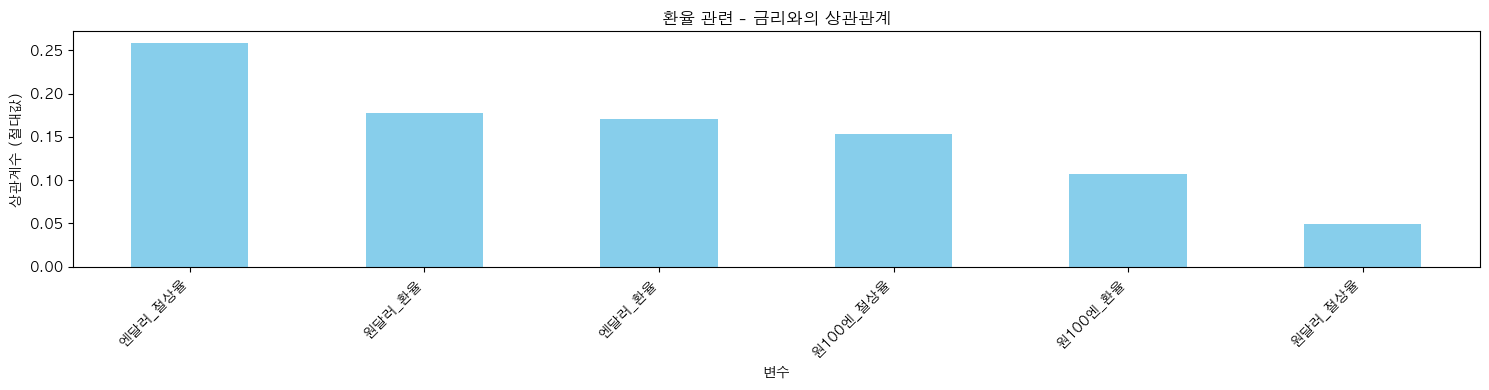

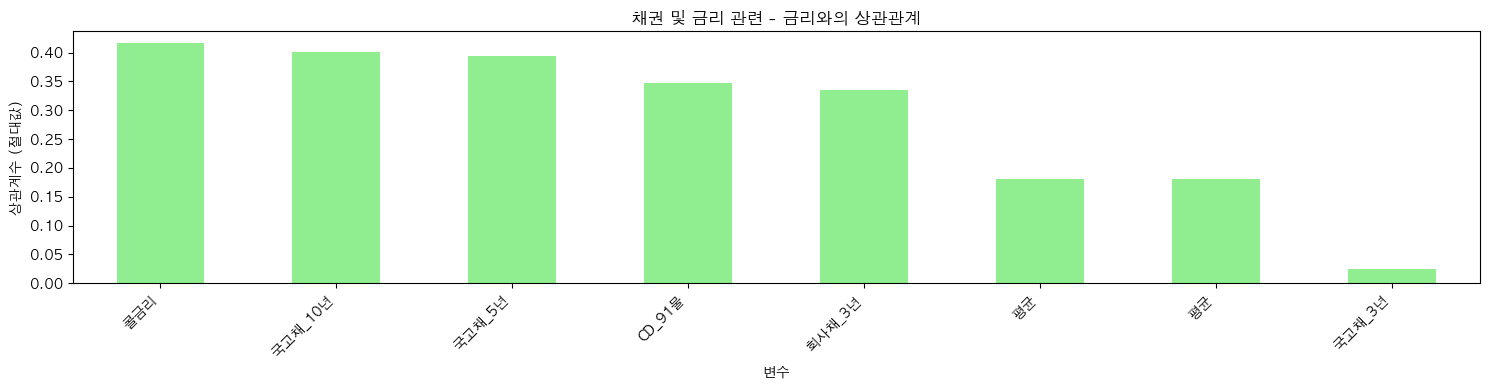

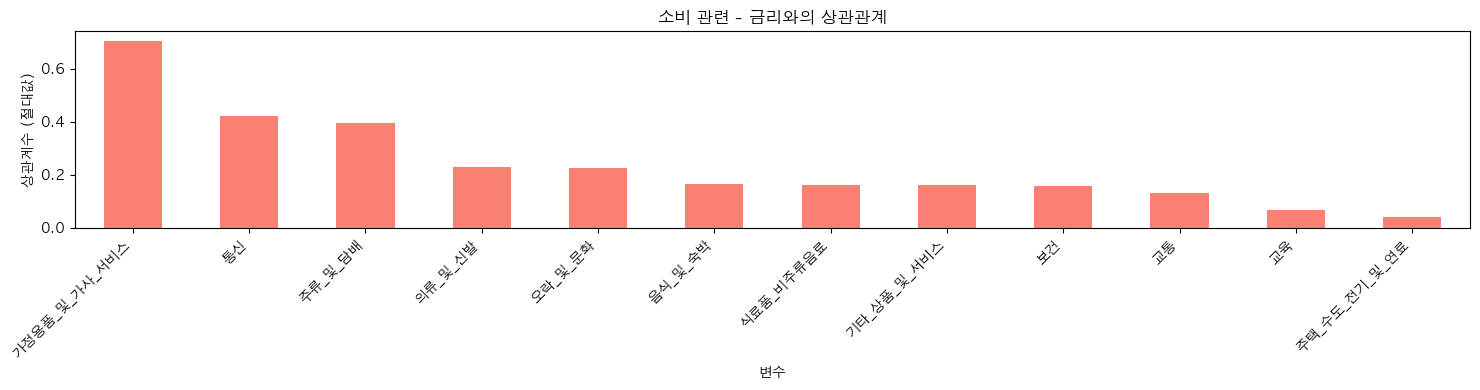

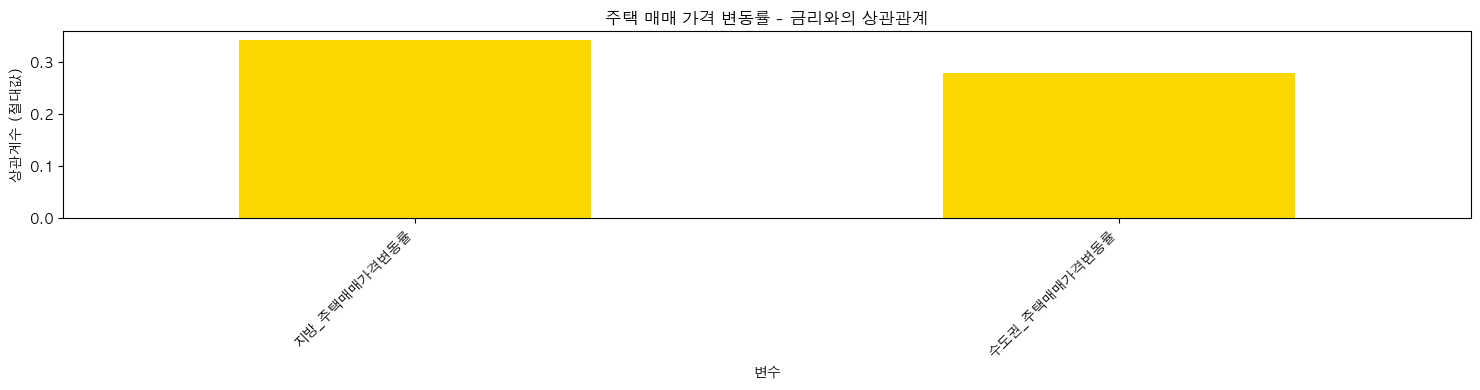

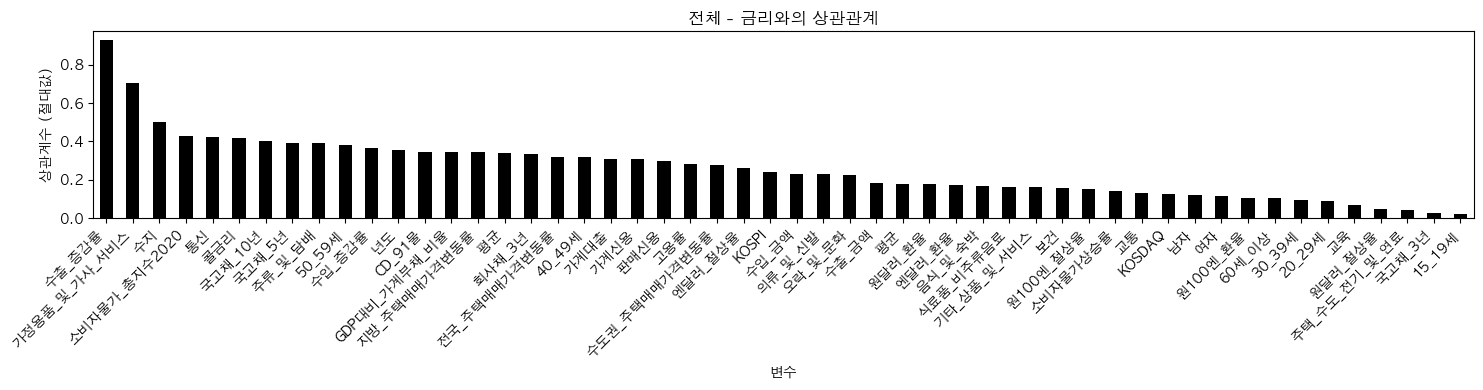

Function 'visualize_grouped_correlations' executed in 0.66 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 seconds
Function 'perform_regression' executed in 0.00 second

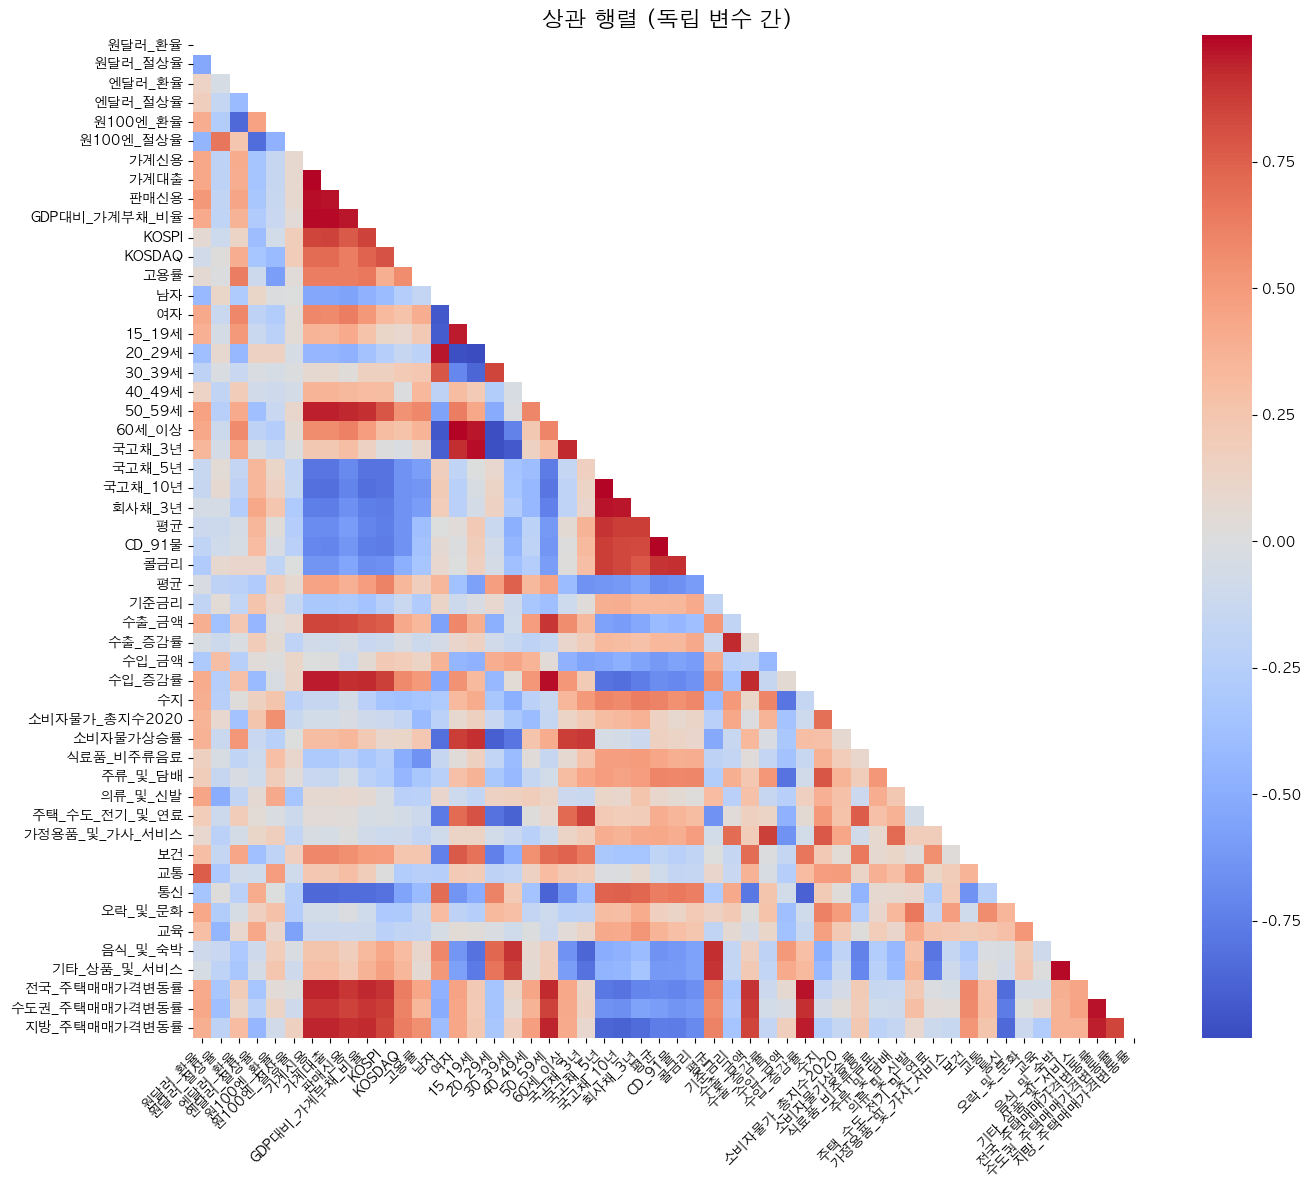

Function 'visualize_correlation_and_find_extremes' executed in 0.35 seconds


상관관계를 확인할 변수를 입력하세요 (종료하려면 '종료' 입력):  원달러_환율


원달러_환율와(과) 기준금리의 상관계수는 -0.178입니다.


상관관계를 확인할 변수를 입력하세요 (종료하려면 '종료' 입력):  보건


보건와(과) 기준금리의 상관계수는 -0.159입니다.


상관관계를 확인할 변수를 입력하세요 (종료하려면 '종료' 입력):  종료


In [8]:
# 데이터 로드
data_handler = DataHandler('/Users/jh/Downloads/dataset.xlsx')
data = data_handler.data

correlation_analyzer = CorrelationAnalyzer(data)

# 그룹별 상관관계 시각화
correlation_analyzer.visualize_grouped_correlations('기준금리')

# 회귀 분석 수행
regression_analyzer = RegressionAnalyzer(data)
regression_analyzer.analyze_interest_rate_effects('기준금리')

# 상관 분석 수행
correlation_matrix = correlation_analyzer.visualize_correlation_and_find_extremes('기준금리')

# 상관관계 검색 기능 실행
correlation_searcher = CorrelationSearcher(correlation_matrix, '기준금리')
correlation_searcher.search_correlation()